## SESONAL DECOMPOSITION OF COMPOSITIONAL DATA

    Transform microbiome time series using CLR. 
    Decompose each time serie using STL with 14 days window
    Plot trend component. 
    
 *** we assume additive time series model as our data is log transformed (STL can be only used to additive time series but we can use STL on log transformed data. As our data is log transformed by CLR we can use STL)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import numpy as np
import seaborn as sns

import os
import sys

from skbio.stats.composition import clr, alr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.forecasting.stl import STLForecast

MODULE_PATH = os.path.abspath('/storage/zkarwowska/predicting-microbiome-in-time/data-processing/data-preparation/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)
    
from processing import MicrobiomeDataPreprocessing, CLRTransformer, MicrobiomeTraintestSplit
from interpolation import Interpolation

### read data, assign dates and transform using CLR

In [240]:
METADATA_FILE = '/storage/zkarwowska/microbiome-interactions/datasets/processed/qiita_550/raw_data/550_metadata.txt'
metadata = pd.read_csv(METADATA_FILE, sep = '\t')
metadata = metadata[(metadata['body_product'] == 'UBERON:feces') & \
                    (metadata['sex'] == 'male') & \
                    (metadata['mislabeled']==False)].sort_values(by = 'days_since_experiment_start')

data = pd.read_csv('/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets_assigned_taxonomy/male_family.csv', index_col=[0])

interpolate_data = interpolator.interpolate_pchip(data) 
data_pseudo = interpolate_data + 1e-5
clr_data = pd.DataFrame(clr(data_pseudo), columns = data.columns)

dates = pd.date_range(start=metadata['collection_timestamp'].min(), end=metadata['collection_timestamp'].max(), freq='D')
clr_data.index = dates
clr_data = clr_data[clr_data.index.year == 2009]

### decompose each time series using STL seasonal decomposition with period = 14 days

In [338]:
TREND_DF = []
for i in range(len(clr_data.columns)):
    
    trend_df = pd.DataFrame(STL(clr_data.iloc[:, i], period= 14, robust = True).fit().trend)
    trend_df['feature'] = clr_data.iloc[:, i].name
    TREND_DF.append(trend_df)
    
TREND_DF = pd.concat(TREND_DF)
TREND_DF = TREND_DF.reset_index()

### plot 

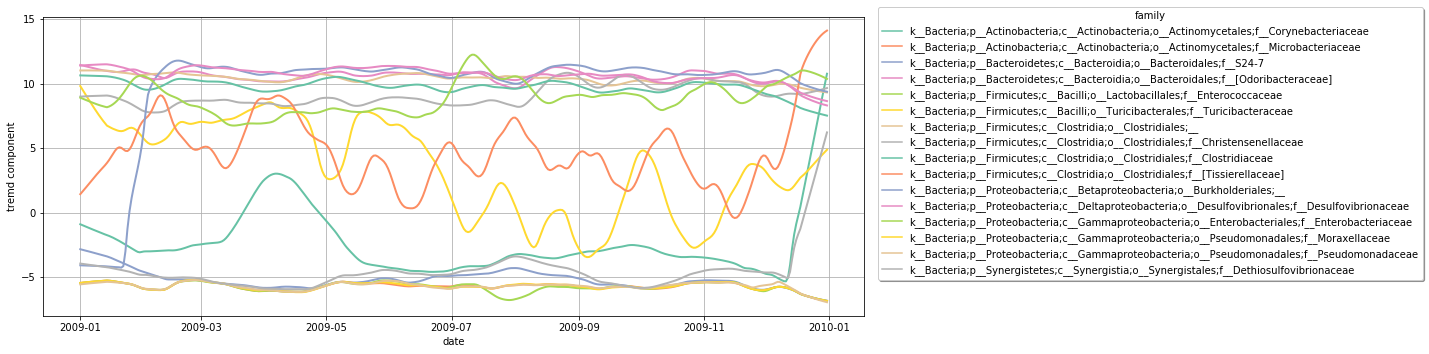

In [357]:
TREND_DF = TREND_DF.rename({'index':'date'}, axis=1).sort_values(by = 'trend')
many = clr_data.iloc[:, 20:25].columns.tolist()
small = clr_data.iloc[:, 60:65].columns.tolist()
medium = clr_data.iloc[:, 30:40].columns.tolist()

keep = many+small+medium

trend_df = TREND_DF[TREND_DF.feature.isin(keep)].sort_values(by='feature')

plt.figure(figsize =(20, 5))
ax=sns.lineplot(x=trend_df.date,
                y=trend_df.trend,
                hue = trend_df.feature, 
                palette=sns.color_palette("Set2", len(keep)),
                #hue=TREND_DF.feature.str.split(';', expand=True).iloc[:, -1],
                linewidth=2)

ax.legend(bbox_to_anchor=(1.01, 1.05), title="family", shadow=True, fontsize=10)
plt.grid()
plt.ylabel('tremd component')
plt.tight_layout()
plt.savefig('male_family_trend.png')

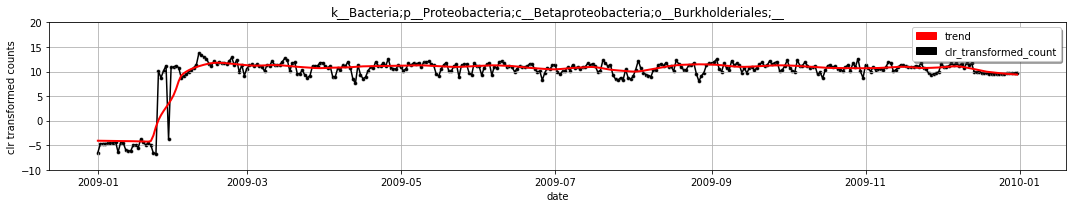

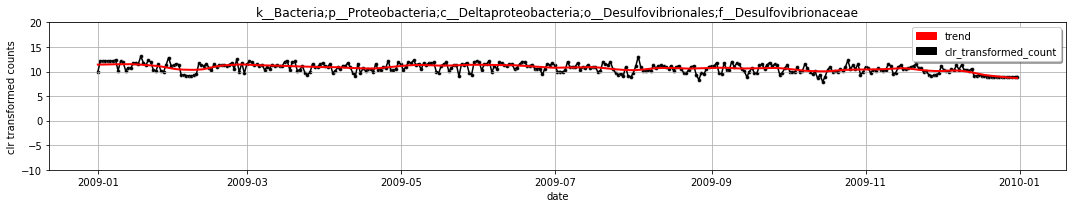

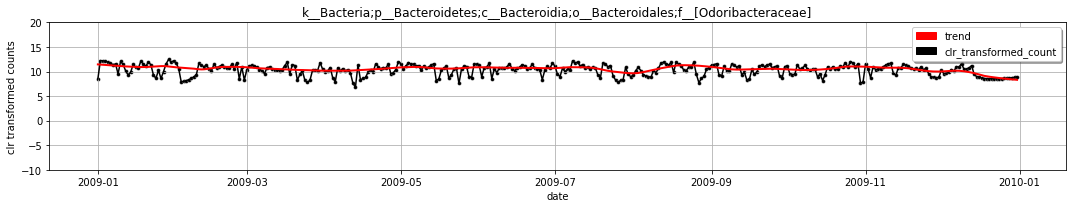

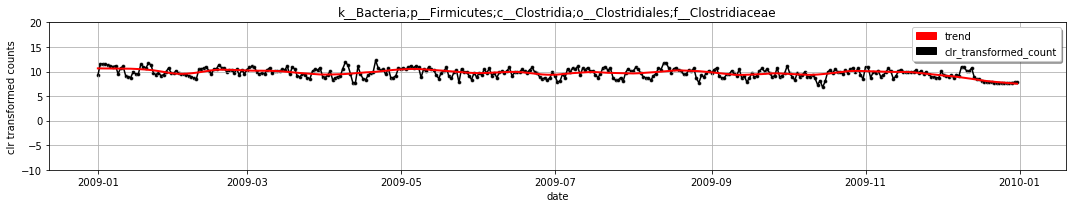

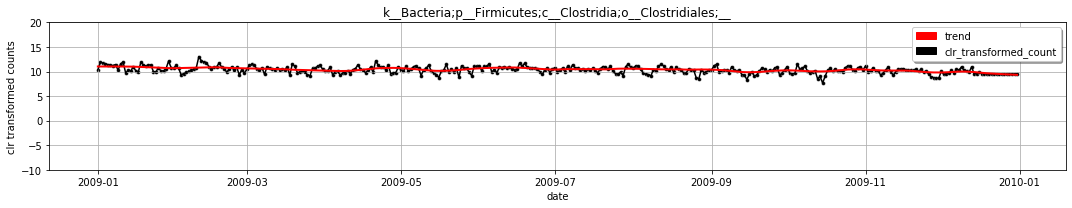

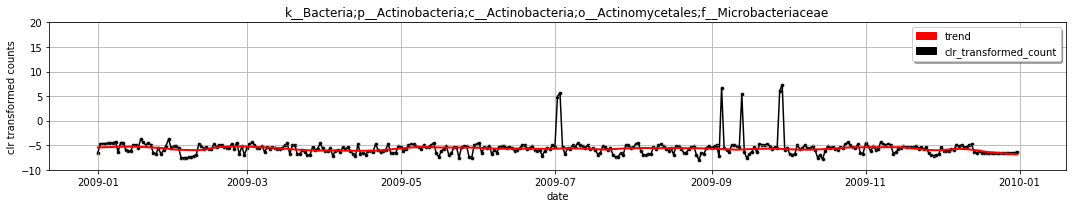

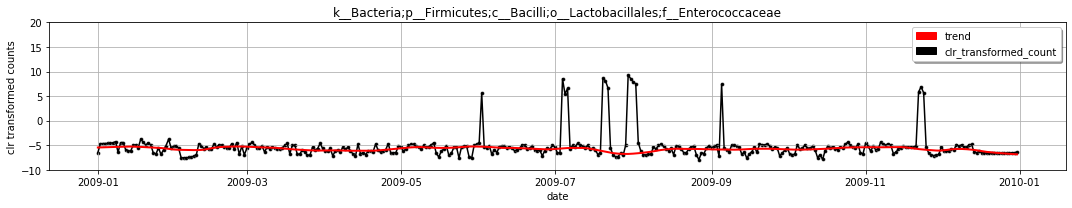

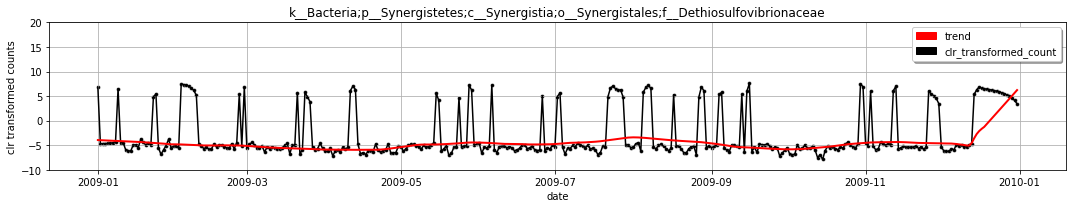

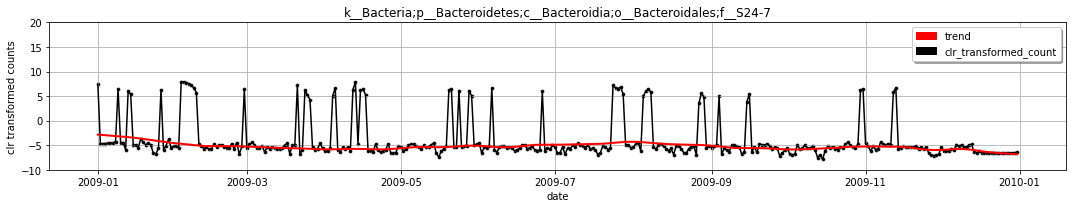

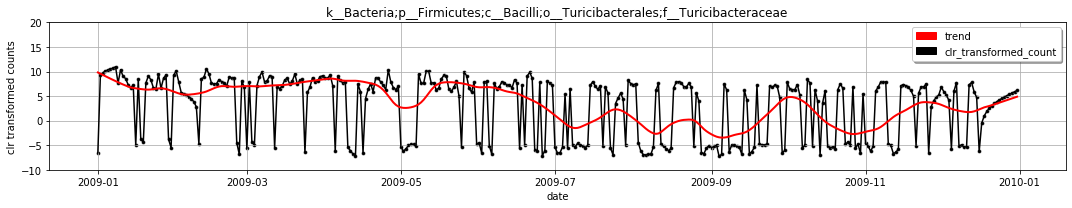

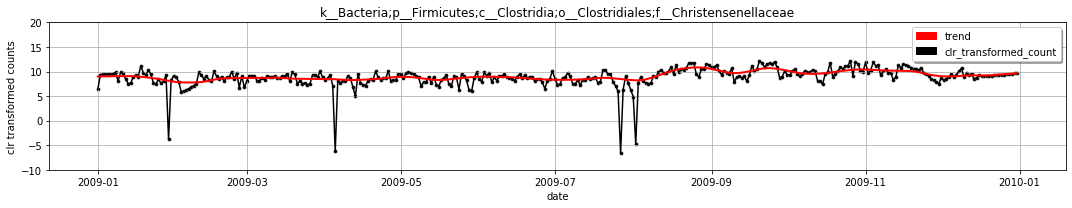

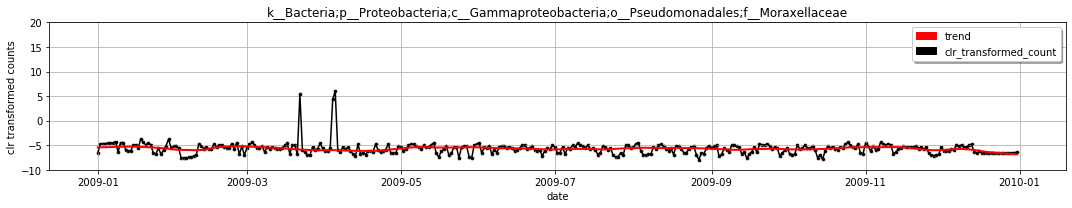

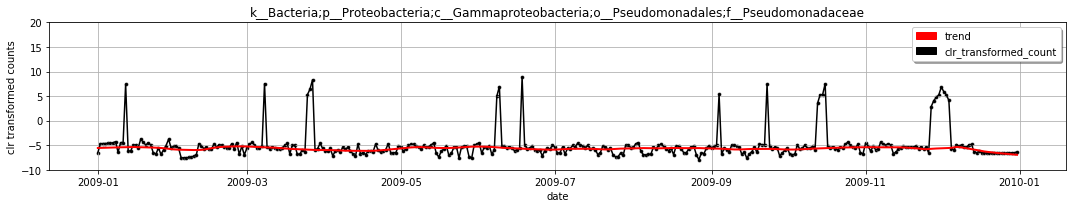

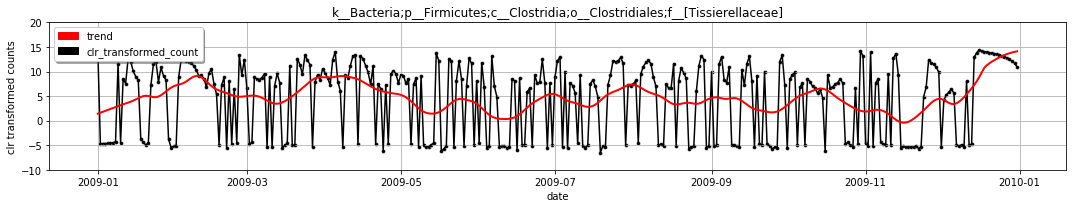

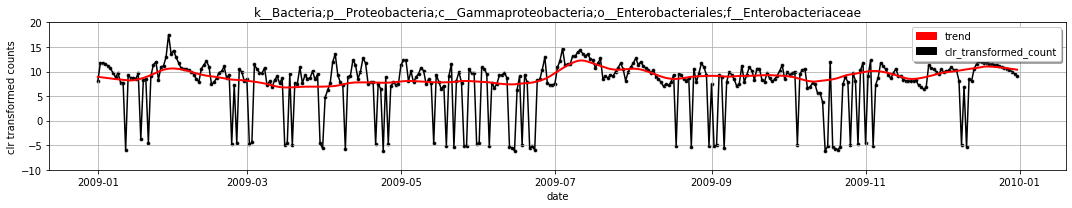

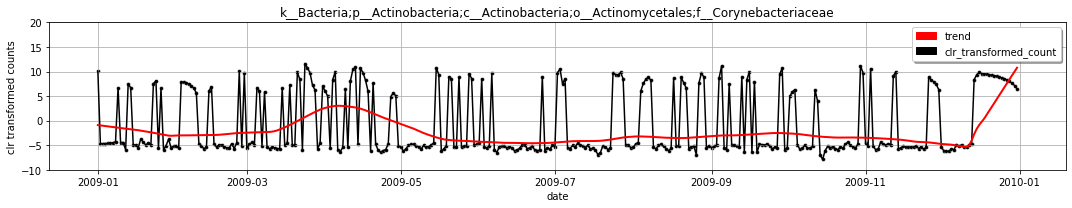

In [ ]:
import matplotlib.patches as mpatches
for col in keep:

    trend_df = TREND_DF[TREND_DF.feature == col]

    plt.figure(figsize =(15, 3))
    sns.lineplot(x = clr_data.index, y=clr_data[col], color='k')
    sns.scatterplot(x = clr_data.index, y=clr_data[col], color='k', s=15)

    sns.lineplot(x=trend_df.date, y=trend_df.trend, color='r', linewidth=2)
    plt.grid()
    plt.ylim([-10, 20])
    red_patch = mpatches.Patch(color='red', label='trend')
    balck_patch = mpatches.Patch(color='black', label='clr_transformed_count')
    plt.legend(handles=[red_patch, balck_patch], shadow=True)
    plt.title(col)
    plt.ylabel('clr transformed counts')
    plt.tight_layout()
    plt.savefig('plots/family_{}_trend.png'.format(col))
    plt.show()